In [3]:
import sys
print(sys.executable)

C:\Users\Netra\anaconda\python.exe


In [6]:
!C:\Users\Netra\anaconda\python.exe -m pip install wordcloud

In [17]:
!pip install nltk
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Netra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [13]:
''' reading data '''
df = pd.read_csv('amazon_alexa.tsv', delimiter='\t')

In [14]:
''' displaying first 5 rows '''
df.head(5)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [11]:
''' checking null values '''
df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [12]:
''' checking info of data '''
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Name: variation, dtype: int64


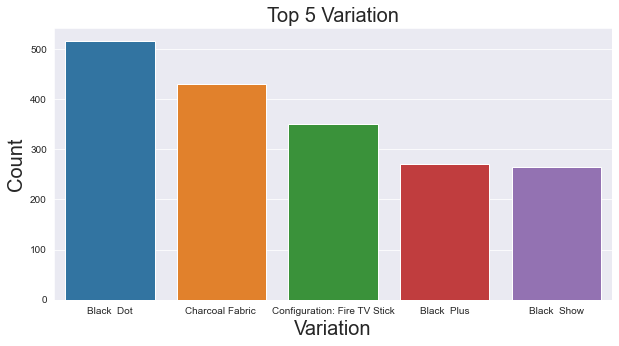

In [14]:
''' value counts of variation '''
variation_label = df.variation.value_counts()[:5]
print(variation_label)

''' plotting top 5 variation '''
plt.figure(figsize=(10, 5))
sns.barplot(variation_label.index, variation_label);
plt.xlabel('Variation', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Top 5 Variation', fontsize=20);

In [13]:
''' shape of data '''
df.shape

(3150, 5)

In [14]:
''' adding a len column for analyzing the length of the reviews '''
df['len'] = df['verified_reviews'].map(len)
df['len']

0        13
1         9
2       195
3       172
4         5
       ... 
3145     50
3146    135
3147    441
3148    380
3149      4
Name: len, Length: 3150, dtype: int64

In [15]:
''' displaying data based on len '''
df.groupby('len').describe().sample(10)

rating                                                feedback            \
     count      mean       std  min   25%  50%   75%  max    count      mean   
len                                                                            
202    2.0  4.500000  0.707107  4.0  4.25  4.5  4.75  5.0      2.0  1.000000   
159    4.0  3.250000  1.500000  2.0  2.00  3.0  4.25  5.0      4.0  0.500000   
698    2.0  4.000000  0.000000  4.0  4.00  4.0  4.00  4.0      2.0  1.000000   
328    1.0  5.000000       NaN  5.0  5.00  5.0  5.00  5.0      1.0  1.000000   
22    35.0  4.285714  1.525690  1.0  5.00  5.0  5.00  5.0     35.0  0.828571   
13    44.0  4.818182  0.495220  3.0  5.00  5.0  5.00  5.0     44.0  1.000000   
773    1.0  4.000000       NaN  4.0  4.00  4.0  4.00  4.0      1.0  1.000000   
147    7.0  4.571429  1.133893  2.0  5.00  5.0  5.00  5.0      7.0  0.857143   
226    1.0  5.000000       NaN  5.0  5.00  5.0  5.00  5.0      1.0  1.000000   
604    1.0  5.000000       NaN  5.0  5.00  5.0  5.00  5.0      1.0  1.000000   

                                        
          std  min  25%  50%  75%  max  
len                                     
202  0.000000  1.0  1.0  1.0  1.0  1.0  
159  0.577350  0.0  0.0  0.5  1.0  1.0  
698  0.000000  1.0  1.0  1.0  1.0  1.0  
328       NaN  1.0  1.0  1.0  1.0  1.0  
22   0.382385  0.0  1.0  1.0  1.0  1.0  
13   0.000000  1.0  1.0  1.0  1.0  1.0  
773       NaN  1.0  1.0  1.0  1.0  1.0  
147  0.377964  0.0  1.0  1.0  1.0  1.0  
226       NaN  1.0  1.0  1.0  1.0  1.0  
604       NaN  1.0  1.0  1.0  1.0  1.0

In [16]:
'''displaying the data according to the Ratings '''
df.groupby('rating').describe()

feedback                                        len              \
          count mean  std  min  25%  50%  75%  max   count        mean   
rating                                                                   
1         161.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   161.0  195.000000   
2          96.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    96.0  249.187500   
3         152.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   152.0  207.296053   
4         455.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   455.0  178.520879   
5        2286.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  2286.0  108.444007   

                                                       
               std  min    25%    50%     75%     max  
rating                                                 
1       212.371226  1.0  36.00  120.0  284.00  1124.0  
2       269.595303  1.0  78.75  163.0  309.25  1686.0  
3       272.194706  1.0  54.00  130.0  284.00  1954.0  
4       215.927849  1.0  34.00   99.0  241.00  1360.0  
5       152.116387  1.0  26.00   64.0  135.00  2851.0

In [17]:
''' displaying data based according to the feedback '''
df.groupby('feedback').describe()

rating                                                  len  \
           count      mean       std  min  25%  50%  75%  max   count   
feedback                                                                
0          257.0  1.373541  0.484688  1.0  1.0  1.0  2.0  2.0   257.0   
1         2893.0  4.737643  0.546544  3.0  5.0  5.0  5.0  5.0  2893.0   

                                                                   
                mean         std  min   25%    50%    75%     max  
feedback                                                           
0         215.241245  236.325955  1.0  53.0  137.0  289.0  1686.0  
1         124.659177  174.624491  1.0  29.0   69.0  154.0  2851.0

5    2286
4     455
1     161
3     152
2      96
Name: rating, dtype: int64


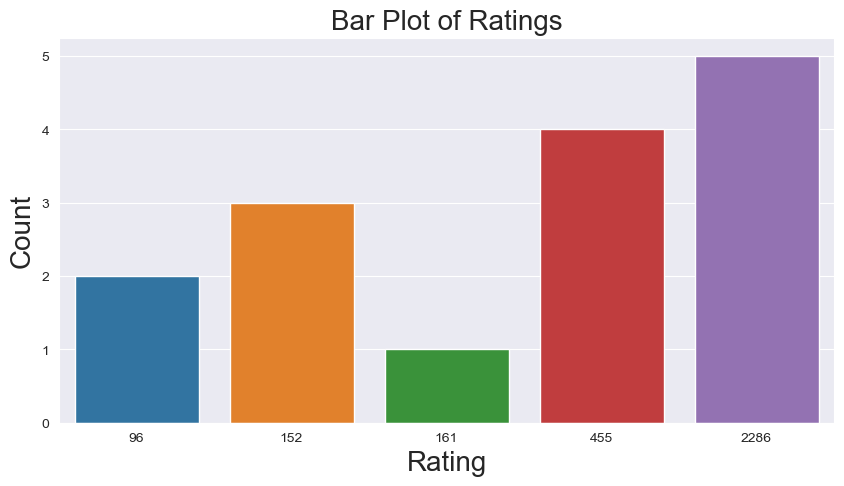

In [33]:
''' visualization '''


''' value counts of rating '''
rating_label = df.rating.value_counts()
print(rating_label)

''' barplot '''
plt.figure(figsize=(10, 5))
sns.barplot(x=rating_label,y=rating_label.index);
plt.xlabel('Rating', fontsize=20)
plt.ylabel('Count', fontsize=20);
plt.title('Bar Plot of Ratings', fontsize=20);


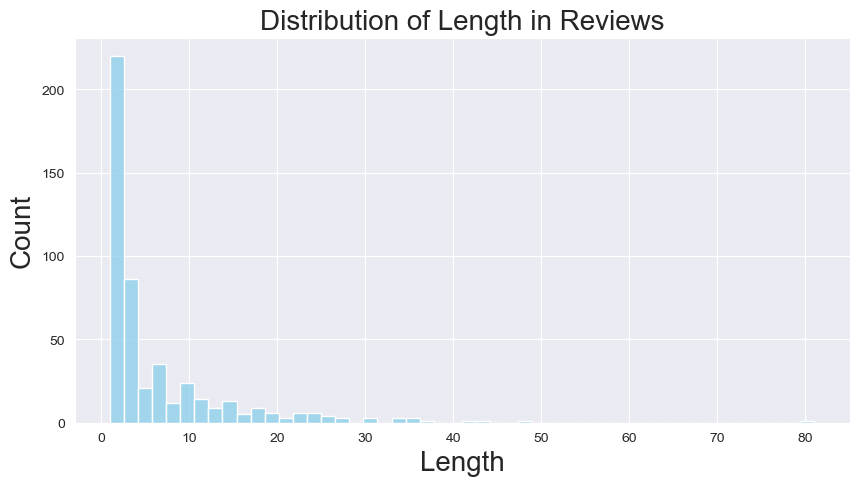

In [19]:
''' histogram plot of len of reivews '''
len_label = df['len'].value_counts()
plt.figure(figsize=(10, 5))
sns.histplot(len_label, bins=50, color='skyblue');
plt.xlabel('Length', fontsize=20)
plt.ylabel('Count', fontsize=20);
plt.title('Distribution of Length in Reviews', fontsize=20);

In [20]:
''' Let's Check some of the reviews according to thier lengths '''
df[df.len == 1]['verified_reviews'].iloc[0]

'😍'

In [21]:
df[df['len'] == 150]['verified_reviews'].iloc[0]

"Got this on Amazon prime with the ring pro. Work really great. Being the lazy guy I am I don't need to go see who at my door anymore while I'm gaming."

In [22]:
df[df['len'] == 50]['verified_reviews'].iloc[0]

'Yet another Exho for our home and love them all!!!'

In [23]:
df[df['len'] == 25]['verified_reviews'].iloc[0]

'I love it, wife hates it.'

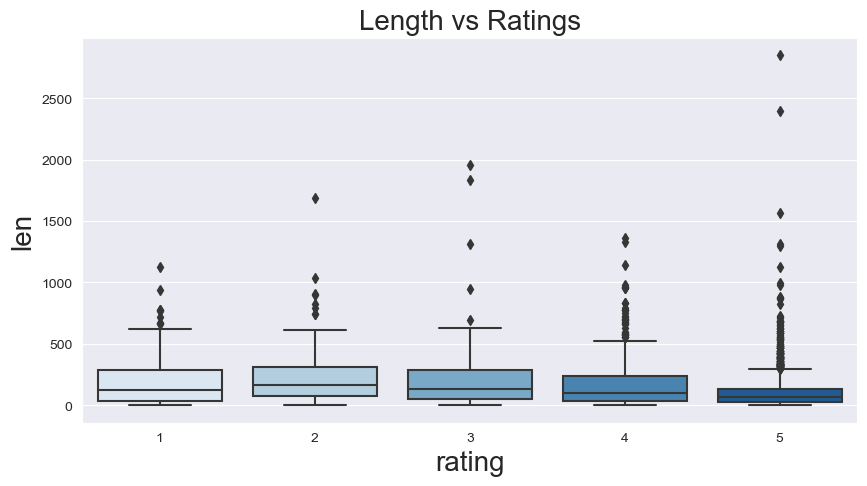

In [34]:
''' box plot '''
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['rating'], y=df['len'], palette = 'Blues')
plt.title("Length vs Ratings", fontsize=20)
plt.xlabel('rating', fontsize=20)
plt.ylabel('len', fontsize=20);

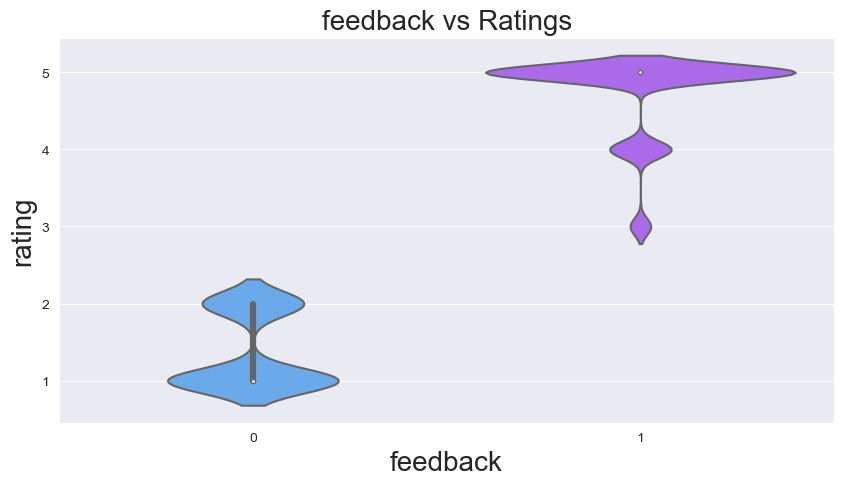

In [35]:
''' violin plot '''
plt.figure(figsize=(10, 5))
sns.violinplot(x=df['feedback'], y=df['rating'], palette = 'cool')
plt.title("feedback vs Ratings", fontsize=20)
plt.xlabel('feedback', fontsize=20)
plt.ylabel('rating', fontsize=20);

In [ ]:
''' swarmplot '''
plt.figure(figsize=(10, 5))
sns.swarmplot(df['variation'], df['len'], palette = 'deep')
plt.title("Variation vs Length of Ratings", fontsize=20)
plt.xticks(rotation = 45);
plt.xlabel('variation', fontsize=20)
plt.ylabel('len', fontsize=20);

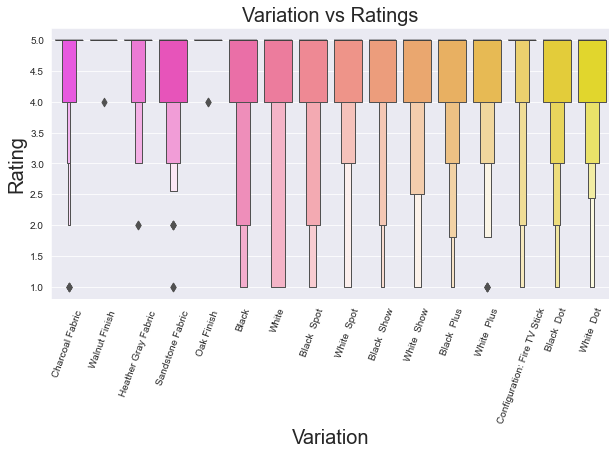

In [55]:
''' bivariate analysis '''
plt.figure(figsize=(10, 5))
sns.boxenplot(df['variation'], df['rating'], palette = 'spring')
plt.title("Variation vs Ratings", fontsize=20)
plt.xticks(rotation = 70);
plt.xlabel('Variation', fontsize=20)
plt.ylabel('Rating', fontsize=20);

In [39]:
''' preprocessing of text '''

''' CountVectorizer '''
count_vector = CountVectorizer(stop_words='english') 

ws = count_vector.fit_transform(df.verified_reviews)
s_w = ws.sum(axis=0)
w_f = [(w, s_w[0, idx]) for w, idx in count_vector.vocabulary_.items()]
w_f = sorted(w_f, key = lambda x: x[1], reverse = True)

''' creating dataframe '''
freq = pd.DataFrame(w_f, columns=['word', 'freq'])

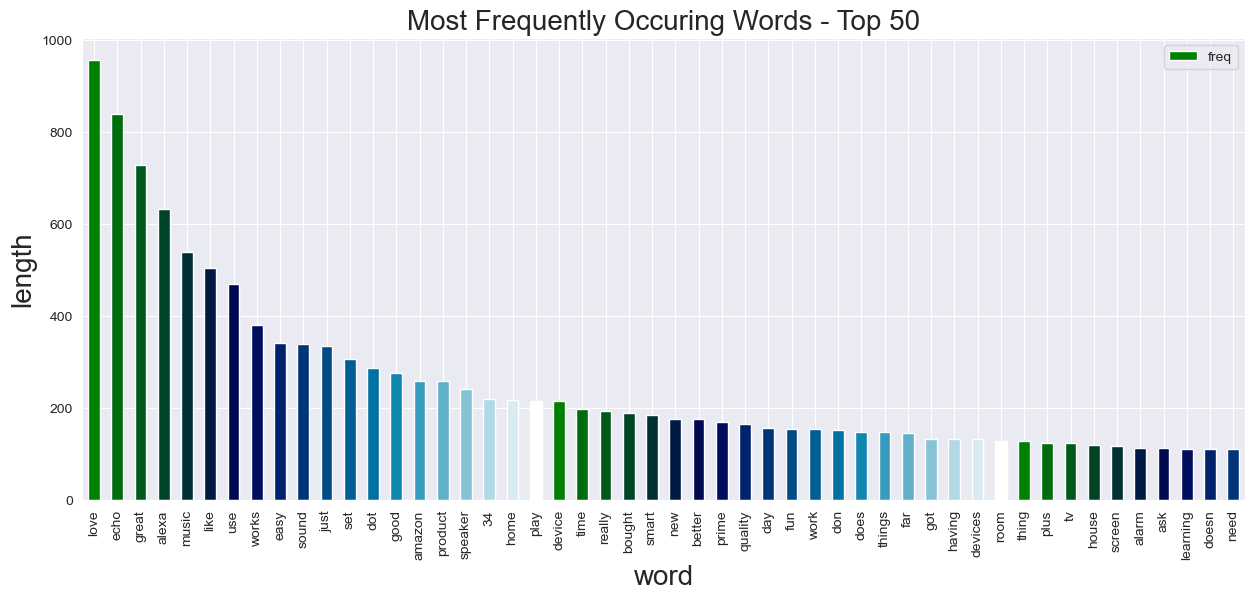

In [40]:
''' barplot of top 50 frequently occuring words '''
color = plt.cm.ocean(np.linspace(0, 1, 20))
freq.head(50).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Most Frequently Occuring Words - Top 50", fontsize=20)
plt.xlabel('word', fontsize=20)
plt.ylabel('length', fontsize=20);

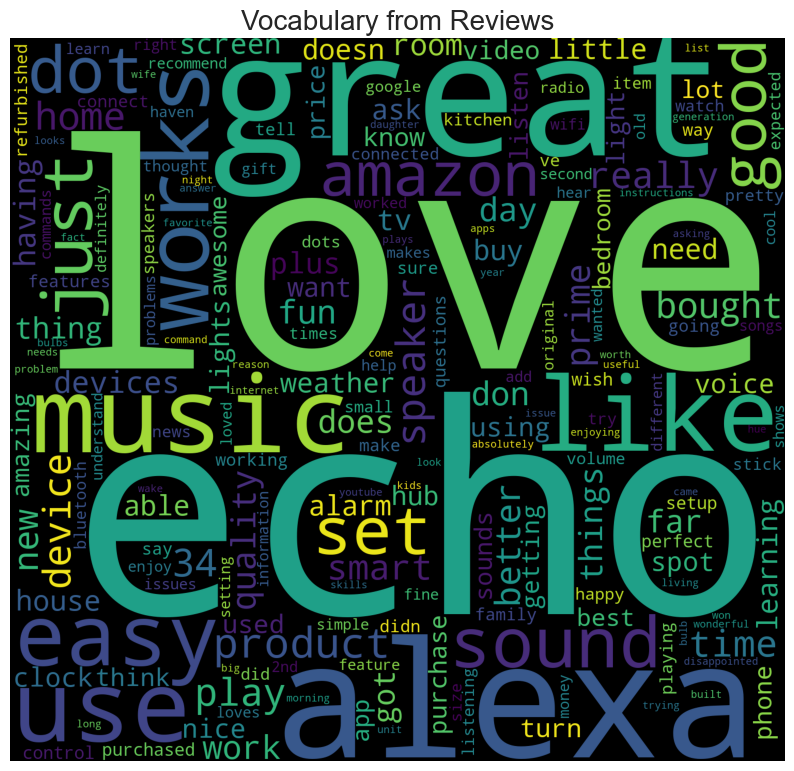

In [41]:
''' representing words on WordCloud '''
word_cloud = WordCloud(background_color='black', width=1500, height=1400).generate_from_frequencies(dict(w_f))
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(word_cloud)
plt.title("Vocabulary from Reviews", fontsize = 20);

In [19]:
''' preproecessing '''
c = []

for i in range(0, 3150):
    ''' removing characters except a-z and A-Z'''
    r = re.sub('[^a-zA-Z]', ' ', df['verified_reviews'][i])
    ''' converting every word into lower word'''
    r = r.lower()
    ''' splitting text '''
    r = r.split()
    ''' apllying Stemming '''
    ps = PorterStemmer()
    ''' removing stopwords '''
    sw = stopwords.words('english')
    sw.remove('not')
    r = [ps.stem(word) for word in r if not word in set(sw)]
    r = ' '.join(r)
    c.append(r)

In [20]:
''' count vectorizer '''
count_vector = CountVectorizer(max_features=2500) 

''' independent and dependent variables '''
X = count_vector.fit_transform(c).toarray()
y = df.iloc[:, 4].values

''' checking shape '''
print(X.shape)
print(y.shape)

(3150, 2500)
(3150,)


In [21]:
''' train test split '''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [22]:
print("shape of X_train: ", X_train.shape)
print("shape of X_test: ", X_test.shape)

shape of X_train:  (2362, 2500)
shape of X_test:  (788, 2500)


In [23]:
''' Min Max Scaler '''
min_max_sc = MinMaxScaler()

X_train = min_max_sc.fit_transform(X_train)
X_test = min_max_sc.transform(X_test)

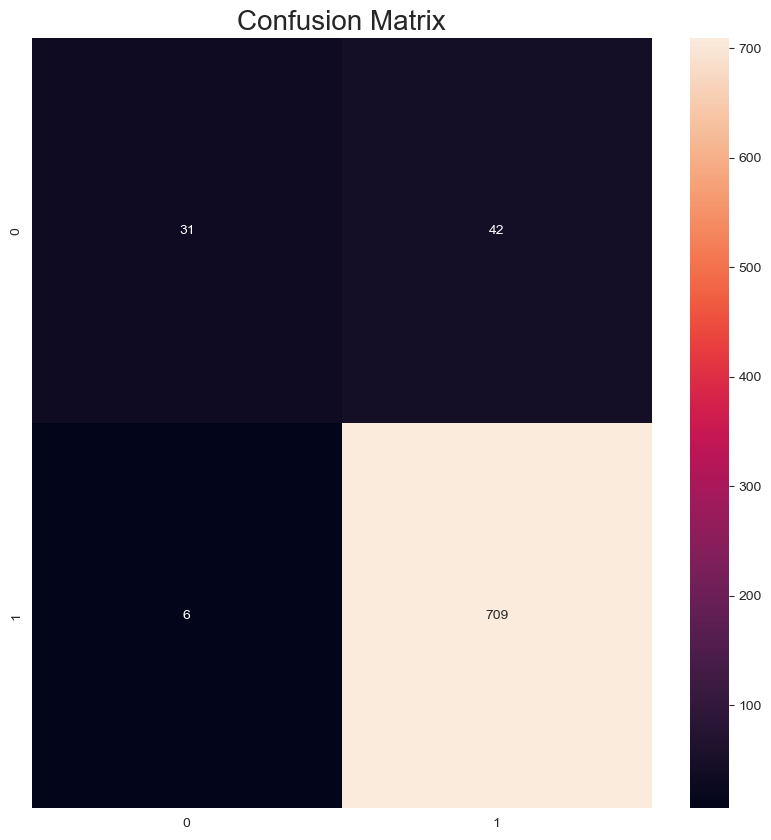

In [24]:
''' Random Forest Classifier '''
rf = RandomForestClassifier()

''' fit on data '''
rf.fit(X_train, y_train)

''' prediction '''
y_pred = rf.predict(X_test)

''' confusion matrix '''
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g');
plt.title('Confusion Matrix', fontsize=20);

In [ ]:
''' Hyperparameter Tunning '''

p = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

''' Grid Search CV '''
grid_cv = GridSearchCV(estimator=rf, param_grid=p, cv=10, verbose=0, scoring='accuracy', n_jobs=-1, 
                       return_train_score=True)
grid_cv.fit(X_train, y_train.ravel())

In [ ]:
print("Best Parameter : {}".format(grid_cv.best_params_))

In [ ]:
rf_cv = RandomForestClassifier(bootstrap=True, max_depth=80, min_samples_split=8, n_estimators=300)

''' fit on data '''
rf_cv.fit(X_train, y_train)

''' prediction '''
pred = rf_cv.predict(X_test)

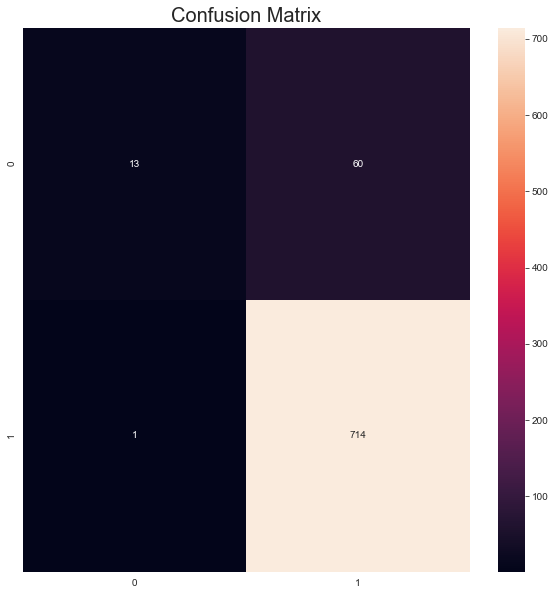

In [94]:
''' confusion matrix '''
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='g');
plt.title('Confusion Matrix', fontsize=20);